# 前處理

1. XGBoost不用處理缺失值，因此不用刪缺失
2. kmeans要記得不要納入weight，因為有缺失值
3. 不要學生化殘差，不要第二階段訓練

In [1]:
# 資料處理套件
import pandas as pd

# 讀取資料
df_combined = pd.read_excel('curb_weight_bigdata_without2022.xlsx') 

In [2]:
'''使機器自動辨別各資料間的關聯，再依可能較相關之資料群進行分群'''

# ML套件
from sklearn.cluster import KMeans

def kmeans_(df):
    
    included = ['Engine Size(L)', 'Cylinders']
    X = df[included]

    model = KMeans(n_clusters = 5, n_init='auto', random_state=1)  # 預計分為5群，迭代次數由模型自行定義
    model.fit(X)  # 建立模型

    df['Cluster'] = model.labels_  #將分類結果加回df
    
    return df

# 將訓練資料進行分群，增加可學習特徵，以提高預測準確度
df_combined = kmeans_(df_combined)

D:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# Two-step Training and Fold-Validation

In [3]:
import xgboost as xgb
import numpy as np
import statsmodels.api as sm  #學生化殘差

'''第一階段訓練'''  

best_params =  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}

def training(df, best_params):  
    global X, y
    X = df[['Engine Size(L)', 'Cylinders', 'Cluster', 'weight']]
    y = df['CO2 Emissions(g/km)']
    
    # 使用最佳超參數建立模型
    best_model = xgb.XGBRegressor(**best_params)

    # 使用最佳超參數對完整的資料進行訓練
    best_model.fit(X, y)

    # 使用最佳超參數對完整的資料進行訓練
    return best_model


best_model = training(df_combined, best_params)

Cross-Validation R^2 Scores: [0.85693629 0.85517714 0.84507672 0.86155178 0.86041229]
Mean of Cross-Validation R^2 Scores: 0.8558308447004974
MAE: 16.100817348705096


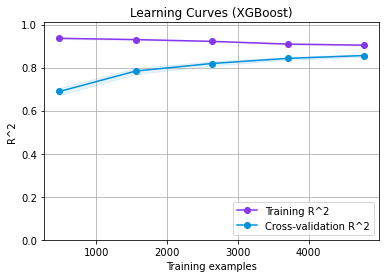

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, KFold, cross_val_score

def plot_learning_curve_r2(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='r2', n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="#8737ED")  # Purple color
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#0091DA")  # Blue color
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#8737ED",  # Purple color
             label="Training R^2")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#0091DA",  # Blue color
             label="Cross-validation R^2")
    
    plt.legend(loc="lower right")
    return plt


# 使用第二階段的最佳模型進行學習曲線繪製
title_second_stage = "Learning Curves (XGBoost)"

# 初始化交叉驗證
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 計算交叉驗證分數
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='r2')  # 使用R^2作為評估標準

# 輸出交叉驗證分數
print("Cross-Validation R^2 Scores:", cv_scores)
print("Mean of Cross-Validation R^2 Scores:", np.mean(cv_scores))

mae_scores = cross_val_score(best_model, X, y, cv=cv, scoring='neg_mean_absolute_error')
# 將分數取平均，並取其相反數
print('MAE:', -mae_scores.mean())

plot_learning_curve_r2(best_model, title_second_stage, X, y, cv=cv, ylim=(0.0, 1.01), n_jobs=1)

plt.show()


# 正式Testing

In [5]:
'''使用者互動介面'''

import tkinter as tk
from tkinter import filedialog
import pandas as pd

class TickerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("碳排預測")
        self.root.geometry("400x400")

        self.current_page = 1
        self.xls = None
        self.file_path = None
        self.TOTAL = None  # 新增全域變數 TOTAL

        # 第一頁
        self.page1_label = tk.Label(root, text="請上傳Excel檔案")
        self.page1_label.pack(pady=20)

        self.upload_button = tk.Button(root, text="上傳檔案", command=self.upload_file)
        self.upload_button.pack(pady=10)

        # 第二頁
        self.page2_label = tk.Label(root, text="請設定上下限")

        # 新增使用者填寫方框
        self.total_label = tk.Label(root, text="目標淘汰數量:")
        self.total_label.pack(pady=5)
        self.total_entry = tk.Entry(root)
        self.total_entry.pack(pady=5)

        self.limits_entries = {}
        self.back_button = tk.Button(root, text="上一步", command=self.prev_page)

    def upload_file(self):
        self.file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx;*.xls")])
        global xls
        try:
            self.xls = pd.read_excel(self.file_path)
            xls = pd.ExcelFile(self.file_path)
            self.show_page2()
        except pd.errors.ParserError:
            self.show_error("error: 檔案格式錯誤")

    def show_page2(self):
        if self.xls is not None:
            self.page1_label.pack_forget()
            self.upload_button.pack_forget()

            self.page2_label.pack(pady=20)

            for key in ['SP', 'PK', 'SEAT', 'Lux', 'L', 'M', 'S']:
                frame = tk.Frame(self.root)
                frame.pack(pady=5)

                label_lower = tk.Label(frame, text=f"{key} 下限:")
                label_lower.pack(side=tk.LEFT)
                entry_lower = tk.Entry(frame)
                entry_lower.pack(side=tk.LEFT)
                self.limits_entries[f"{key}_lower"] = entry_lower

                label_upper = tk.Label(frame, text=f"{key} 上限:")
                label_upper.pack(side=tk.LEFT)
                entry_upper = tk.Entry(frame)
                entry_upper.pack(side=tk.LEFT)
                self.limits_entries[f"{key}_upper"] = entry_upper

            # 提交按鈕
            self.submit_button = tk.Button(self.root, text="提交", command=self.submit_limits)
            self.submit_button.pack(pady=10)

            self.current_page = 2
        else:
            self.show_error("請先上傳Excel檔案")

    def prev_page(self):
        self.page2_label.pack_forget()
        self.submit_button.pack_forget()  
        self.page1_label.pack(pady=20)
        self.upload_button.pack(pady=10)

    def submit_limits(self):
        # 條件判斷：每一個上限必須大於或等於下限
        global limits_values, TOTAL
        for key in ['SP', 'PK', 'SEAT', 'Lux', 'L', 'M', 'S']:
            upper_limit = float(self.limits_entries[f"{key}_upper"].get())
            lower_limit = float(self.limits_entries[f"{key}_lower"].get())
            if upper_limit < lower_limit:
                self.show_error(f"{key} 上限必須大於或等於下限")
                return

        # 新增將使用者填寫之數字傳到全域變數 TOTAL
        try:
            self.TOTAL = int(self.total_entry.get())
        except ValueError:
            self.show_error("目標淘汰數量應為整數")
            return
        
        TOTAL = self.TOTAL
        limits_values = {key: {'上限': self.limits_entries[f"{key}_upper"].get(),
                               '下限': self.limits_entries[f"{key}_lower"].get()} for key in ['SP', 'PK', 
                                                                                            'SEAT', 'Lux', 'L', 'M', 'S']}
        print("上下限:", limits_values)
        print("目標淘汰數量:", self.TOTAL)

        # 回傳 file_path
        self.root.destroy()

    def show_error(self, message):
        error_label = tk.Label(self.root, text=message, fg="red")
        error_label.pack(pady=10)

if __name__ == "__main__":
    root = tk.Tk()
    app = TickerApp(root)
    root.mainloop()


上下限: {'SP': {'上限': '5', '下限': '0'}, 'PK': {'上限': '21', '下限': '13'}, 'SEAT': {'上限': '5', '下限': '0'}, 'Lux': {'上限': '0', '下限': '0'}, 'L': {'上限': '34', '下限': '26'}, 'M': {'上限': '32', '下限': '24'}, 'S': {'上限': '25', '下限': '17'}}
目標淘汰數量: 100


In [6]:
'''以2022年，分類好的資料進行testing'''

def input_preprocess(file_path):
    # 讀取excel
    sheets = xls.sheet_names

    # 基於 '資料集' 工作表創建一個新的 df
    df = pd.read_excel(xls, sheet_name='資料集')

    for sheet in ['Special Purpose', 'Pickup', '2-seater', '豪車', 'Large', 'Medium', 'Small']:
        # 將每個工作表的資料加入到 df 中，使用 1 和 0 表示是否在該工作表中
        df[sheet] = (df['Model'].isin(xls.parse(sheet)['Model'])).astype(int)
    
    return df

df_formal = input_preprocess(xls)

In [7]:
from sklearn.metrics import r2_score, mean_absolute_error

def predict_(df_formal, best_model):
    
    # 用 k-means 自動分群
    df_formal = kmeans_(df_formal)
    
    X_formal = df_formal[['Engine Size(L)', 'Cylinders', 'Cluster', 'weight']]
    y_formal = df_formal['CO2 Emissions(g/km)']

    # 最終資料集預測
    y_formal_pred = best_model.predict(X_formal)

    # 計算及輸出預測性能指標
    print(f"1. Test R^2: {r2_score(y_formal, y_formal_pred)}")
    print(f"2. Test MAE: {mean_absolute_error(y_formal, y_formal_pred)}")

    # 新增預測值欄位到 DataFrame
    df_formal['Predicted_CO2'] = y_formal_pred

    return df_formal

# 分別用 car 跟 truck 的專屬 model 進行預測
df_formal = predict_(df_formal, best_model)

1. Test R^2: 0.7593465191256726
2. Test MAE: 23.638075862828067


D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


# 線性規劃

In [8]:
from pulp import LpProblem, LpVariable, lpSum, LpMaximize, value

def LN(df, co2COL, pickCOL):
    # 將欄位名稱依序替換
    df.rename(columns={
        'Special Purpose': 'SP',
        'Pickup': 'PK',
        '2-seater': 'SEAT',
        '豪車': 'Lux',
        'Large': 'L',
        'Medium': 'M',
        'Small': 'S'
    }, inplace=True)
    
    # 創建 PuLP 線性規劃模型
    model = LpProblem(name="Maximize-CO2-Emissions", sense=LpMaximize)

    # 創建二元變數，表示每輛車是否被選中
    selection_vars = [LpVariable(f'Selection_{i}', cat='Binary') for i in range(len(df))]
    
    # 限制式: 每一種類所挑選數量的限制
    for key, limits in limits_values.items():
        indices = list(df.index[df[key] == 1])
        lower_limit = int(limits['下限'])
        upper_limit = int(limits['上限'])
        model += lpSum(selection_vars[i] for i in indices) >= lower_limit, f"{key} lower limit"
        model += lpSum(selection_vars[i] for i in indices) <= upper_limit, f"{key} upper limit"

    # 限制式: SP+PK+SEAT+L+M+S=100 (淘汰100台)
    model += lpSum(selection_vars) == TOTAL, f"Total {TOTAL} vehicles"

    # 目標式: 最大化 CO2 排放量
    model += lpSum([df[co2COL][i] * selection_vars[i] for i in range(len(df))])

    # 解決模型
    model.solve()

    # 將選中的車輛標記到新的 'select' 欄位中
    df[pickCOL] = [round(value(var)) for var in selection_vars]
    
    return df

In [9]:
df_formal = LN(df_formal, 'Predicted_CO2', 'select')

df_compare = input_preprocess('Final_split_data.xlsx')
df_compare = LN(df_compare, 'CO2 Emissions(g/km)', 'Eliminated')

# testing之預測性能比較

In [10]:
'''將預測產出df與直接產出df匹配後合併'''
# 選擇用於匹配的欄位
matching_columns = ['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission']

# 進行匹配
merged_df = pd.merge(df_compare, df_formal, how='inner', on=matching_columns)

In [11]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

# 提取真實情況和預測情況的欄資料
y_true = merged_df['Eliminated']  
y_pred = merged_df['select']

# 混淆矩陣及分類報告
print("Confusion Matrix:\n", confusion_matrix(df_compare['Eliminated'], df_formal['select']))  # 後為預測
print("\nClassification Report:\n", classification_report(df_compare['Eliminated'], df_formal['select']))

Confusion Matrix:
 [[800  46]
 [ 46  54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       846
           1       0.54      0.54      0.54       100

    accuracy                           0.90       946
   macro avg       0.74      0.74      0.74       946
weighted avg       0.90      0.90      0.90       946



In [12]:
def output_(df, col, co2):

    # 計算 To_Eliminate 為 1 的 CO2 Emissions(g/km) 加總
    Q_eliminate = df[col].sum()
    sum_co2_to_eliminate = df.loc[df[col] == 1, co2].sum()
    average_co2_to_eliminate = df.loc[df[col] == 1, co2].mean()
    year_co2_to_eliminate = sum_co2_to_eliminate*41.1*1.6*365/1000000
                # 交通部統計：每次41.1km，每天1.6次 = 每年2.4萬公里。g換算為噸。
    
    # 印出淘汰數量，節省加總，節省平均
    print("欲淘汰數量：", int(Q_eliminate),"輛"
          f"\n節省 CO2 Emissions 加總：{int(sum_co2_to_eliminate)}g/km"
          f"\n節省 CO2 Emissions 平均：{round(average_co2_to_eliminate, 2)}g/km"
          f"\n節省 CO2 Emissions 每年{round(year_co2_to_eliminate, 2)}噸，",
          f"大約等於 {round(year_co2_to_eliminate*2204.6/1760.0*0.40469, 2)} 公頃樺木林的固碳能力")   
            # 噸換成磅，固碳每英畝1760磅來自論文，一英畝=0.40469公頃(國際單位)


    # 印出淘汰碳排明細
    to_eliminate_rows = df[df[col] == 1]
    print("\n欲淘汰車輛之碳排明細：", )
    for i in to_eliminate_rows['CO2 Emissions(g/km)']:
        print(i,end = ', ')
    
    return(year_co2_to_eliminate)

In [13]:
print('\n------------------------預測結果------------------------')
forcast = output_(df_formal, 'select', 'Predicted_CO2')
    
# 將報告保存為CSV文件
df_formal.to_csv('FinalData_eliminated_cars_report.csv', index=False)


------------------------預測結果------------------------
欲淘汰數量： 100 輛
節省 CO2 Emissions 加總：32126g/km
節省 CO2 Emissions 平均：321.26g/km
節省 CO2 Emissions 每年771.1噸， 大約等於 390.89 公頃樺木林的固碳能力

欲淘汰車輛之碳排明細：
279, 321, 189, 374, 353, 302, 311, 288, 346, 356, 465, 299, 364, 302, 299, 323, 387, 301, 368, 296, 392, 268, 353, 353, 355, 326, 363, 286, 264, 256, 355, 349, 353, 297, 329, 345, 352, 352, 385, 366, 287, 339, 352, 359, 352, 353, 227, 219, 215, 331, 323, 241, 352, 345, 260, 385, 329, 337, 233, 345, 345, 261, 327, 345, 256, 341, 321, 345, 385, 362, 259, 305, 305, 212, 281, 325, 329, 262, 330, 296, 261, 230, 325, 284, 320, 275, 300, 273, 230, 252, 259, 245, 218, 323, 247, 298, 314, 214, 238, 188, 

In [14]:

print('\n\n------------------------實際結果------------------------')
actual = output_(df_compare, 'Eliminated', 'CO2 Emissions(g/km)')

print(f'\n\n每年 CO2 Emissions 節省量，實際與預測之誤差： { round((1 - forcast/actual)*100, 2)}%') 



------------------------實際結果------------------------
欲淘汰數量： 100 輛
節省 CO2 Emissions 加總：32747g/km
節省 CO2 Emissions 平均：327.47g/km
節省 CO2 Emissions 每年786.01噸， 大約等於 398.44 公頃樺木林的固碳能力

欲淘汰車輛之碳排明細：
374, 353, 364, 288, 346, 356, 465, 299, 364, 302, 299, 323, 387, 301, 296, 359, 368, 296, 392, 370, 353, 353, 292, 323, 235, 292, 293, 355, 357, 363, 293, 355, 349, 353, 297, 352, 352, 385, 366, 233, 287, 339, 352, 359, 352, 353, 354, 354, 323, 361, 364, 381, 297, 303, 323, 241, 352, 354, 336, 345, 260, 385, 337, 359, 339, 354, 380, 358, 336, 345, 261, 345, 256, 332, 345, 245, 385, 358, 362, 281, 380, 359, 360, 381, 336, 237, 296, 247, 395, 280, 248, 291, 247, 246, 298, 314, 246, 281, 261, 238, 

每年 CO2 Emissions 節省量，實際與預測之誤差： 1.9%


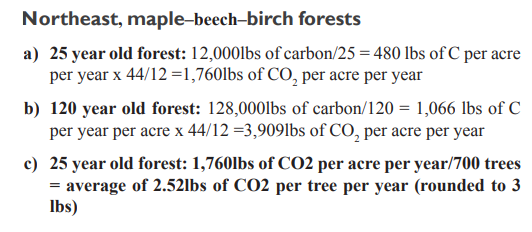